In [1]:
import pandas as pd
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset

In [2]:
def clean_text(text):
    text = re.sub(r'http\S+|@\w+|#\w+|[^a-zA-Z\s]', '', text)
    return text.strip().lower()

In [3]:
df = pd.read_csv('sentiment140.csv', encoding='latin-1', header=None)
df = df[[0, 5]]
df.columns = ['label', 'tweet']
df = df.sample(frac=0.1, random_state=42)

df['label'] = df['label'].replace({0: 0, 2: 1, 4: 2})
df['tweet'] = df['tweet'].apply(clean_text)
df.head()

,label,tweet
541200,0,ahhh i hope your ok
750,0,cool i have no tweet apps for my razr
766711,0,i know just family drama its lamehey next tim...
285055,0,school email wont open and i have geography s...
705995,0,upper airways problem


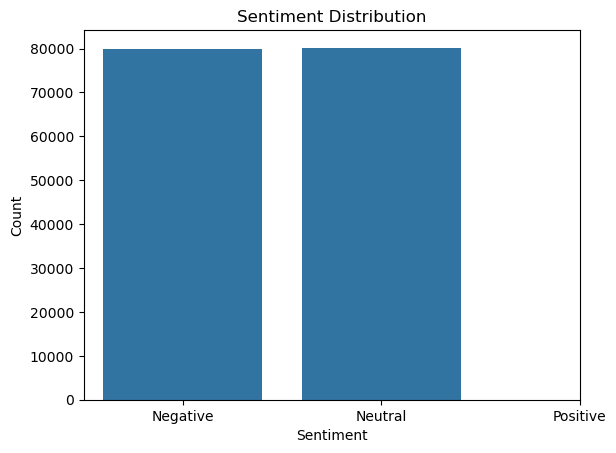

In [4]:
sns.countplot(x='label', data=df)
plt.title('Sentiment Distribution')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.savefig('sentiment_distribution.png')
plt.show()

In [5]:
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(example):
    return tokenizer(example['tweet'], padding='max_length', truncation=True, max_length=128)

In [7]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/144000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

In [8]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy='epoch',
    eval_accumulation_steps=1,
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True
)

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'f1': f1}

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kareemn637 (kareemn637-bfcai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.468400,0.398109,0.828438,0.828275
2,0.248100,0.391346,0.837000,0.836867
3,0.208200,0.547685,0.832937,0.832906


TrainOutput(global_step=27000, training_loss=0.31099411258874116, metrics={'train_runtime': 9473.2517, 'train_samples_per_second': 45.602, 'train_steps_per_second': 2.85, 'total_flos': 2.8416249114624e+16, 'train_loss': 0.31099411258874116, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.3913462162017822,
 'eval_accuracy': 0.837,
 'eval_f1': 0.836867152226374,
 'eval_runtime': 105.4043,
 'eval_samples_per_second': 151.796,
 'eval_steps_per_second': 2.372,
 'epoch': 3.0}

In [ ]:
model.save_pretrained("./my_sentiment_model")
tokenizer.save_pretrained("./my_sentiment_model")

In [ ]:
import shutil
shutil.make_archive('/content/my_sentiment_model', 'zip', '/content/my_sentiment_model')
files.download('/content/my_sentiment_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>